In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from tqdm import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# Import NLTK libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Applying filter to seperate restaurants data using features.
t1=data.categories.value_counts().reset_index()
filter=list(t1.head(108)['index'])
filter_id=list(data[data.categories.isin(filter)]['review_id'])
final=pd.read_csv('final_feature_reviews.csv')
final['review_stars']=final['review_stars'].apply(lambda x : int(x-1))
final=pd.merge(left=final, right=data[['review_id','useful','funny','cool','is_open','business_stars']], on='review_id', how='left')

In [ ]:
# Import Pandas
import pandas as pd
# Read the final_rest_feature_reviews file (Features for restaurant file)
data=pd.read_csv('final_rest_data.csv')
data=data[['text','review_stars']]

# Cleaning the data by dropping Null value data
data['text'].dropna(inplace=True)
# Use lowercace for the text in clean_text
data['clean_text']=[i.lower() for i in data['text']]
# Use word_tokenize for data in clean text which is used to split large sample of text into words
data['clean_text']=[word_tokenize(i) for i in data['clean_text']]
# Take clean text and review_stars for modelling
data=data[['clean_text','review_stars']]

In [ ]:
# Word Lemmatizer initially understands a word as Noun. To categorize a word with POS tag, word lemmatizer 
# needs to understand whether it is an adjective or verb or adverb.
t_map = defaultdict(lambda : wn.NOUN)
t_map['J'] = wn.ADJ
t_map['V'] = wn.VERB
t_map['R'] = wn.ADV

In [ ]:
for ind,ent in tqdm(enumerate(data['clean_text'])):
    # Declare a list to store the words
    word_list = []
    # Initialize WordNetLemmatizer()
    w_Lemmatized = WordNetLemmatizer()
    # pos_tag function provides the 'tag' for the words whether it is a Noun(N) or Verb(V) or something.
    for wrd, tag in pos_tag(ent):
        # consider only alphabets and check for Stop words
        if wrd not in stopwords.words('english') and wrd.isalpha():
            w_Final = w_Lemmatized.lemmatize(wrd,t_map[tag[0]])
            word_list.append(w_Final)
    # After every iteration, list of processede words will be stored in 'text_final'
    data.loc[ind,'text_final'] = str(word_list)




66831it [29:10, 38.19it/s]


In [ ]:
data.shape

(66831, 3)

In [ ]:
data.to_csv('full_rest_data_tfidf.csv', index=False)


In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(data['text_final'],data['review_stars'],test_size=0.3)

# Encode the target variable to transform Categorical data of string type into numerical values
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

# Vectorize the words by using TF-IDF Vectorizer to find how important a word in document compared to corpus
tfidf_v = TfidfVectorizer(max_features=5000)
tfidf_v.fit(data['text_final'])

Train_X_Tfidf = tfidf_v.transform(Train_X)
Test_X_Tfidf = tfidf_v.transform(Test_X)

In [10]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  61.72568578553616


In [ ]:
# Download the ".pkl" file direct model execution
from sklearn.externals import joblib
joblib.dump(SVM, 'svm_only_rest_cat.pkl')

In [12]:
# Cross tab for actual vs Predicted
pd.crosstab(Test_Y,predictions_SVM)

col_0,0,1,2,3,4
row_0,,,,,
0,1642,359,111,67,67
1,470,584,415,171,97
2,206,360,1024,853,258
3,75,101,474,2441,2088
4,71,36,125,1270,6685


In [ ]:
Train_X.shape, Train_X_Tfidf.shape

((46781,), (46781, 5000))

In [2]:
# Loading the data to analyse the trend
trend_data=pd.read_csv("final_rest_data.csv")
trend_data.head(1)

,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date,name,address,city,state,postal_code,latitude,longitude,business_stars,review_count,is_open,attributes,categories,hours
0,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11,Deagan's Kitchen & Bar,14810 Detroit Ave,Lakewood,OH,44107,41.485192,-81.800145,4.0,417.0,1.0,NaN,"Restaurants, Gastropubs, Nightlife, American (...",NaN


In [8]:
# Based on restaurants filter, map the buiness id with the restaurant id 
trend_rest=trend_data[trend_data.business_id=='rcaPajgKOJC2vo_l3xa42A']
# Storing date and review 
trend_rest=trend_rest[['date','review_stars']]
trend_rest['date']=pd.to_datetime(trend_rest['date'])
trend_rest['year']=trend_rest['date'].apply(lambda x : str(x)[0:4])
trend_rest.head(20)

,date,review_stars,year
53,2011-11-30 00:51:49,5.0,2011
110,2016-01-04 04:06:15,4.0,2016
311,2012-11-06 06:27:17,5.0,2012
407,2016-07-03 16:50:57,5.0,2016
429,2010-11-22 05:17:02,4.0,2010
476,2010-11-22 05:21:18,4.0,2010
595,2008-12-03 23:01:31,4.0,2008
751,2018-08-04 21:24:32,5.0,2018
950,2013-05-07 01:49:07,4.0,2013
1014,2009-05-21 14:42:13,2.0,2009


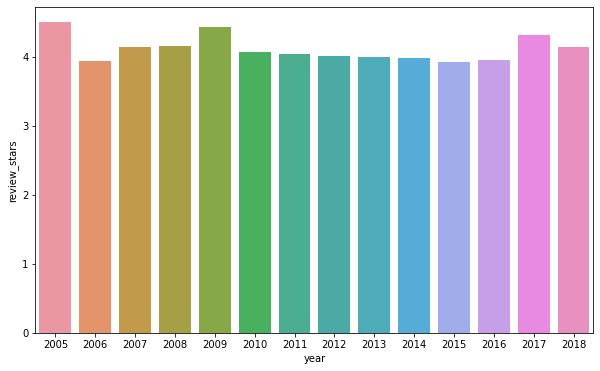

In [6]:
trend=trend_rest[['year','review_stars']].groupby('year')['review_stars'].mean().reset_index()
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="year", y="review_stars",data=trend)

For a business ID: rcaPajgKOJC2vo_l3xa42A, the review rating from 2005 to 2013 remained almost from 3.9 to 4.2. Overall there was no drastic downfall in the yearly rating. So, by this, reviews and ratings helped the restaurants to know their customer's feedback and make changes in order to improve their business.